<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/ADMM/ATM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

def generate_country_data(country_id, num_days=100):
    np.random.seed(country_id)

    day_of_week = np.arange(num_days) % 7
    day_of_month = (np.arange(num_days) % 30) + 1
    is_holiday = np.random.choice([0, 1], size=num_days, p=[0.85, 0.15])

    # Strong linear base influenced by days and holidays
    base = 5000 + 20 * day_of_week + 10 * day_of_month - 50 * is_holiday

    # Country-specific pattern
    if country_id == 1:
        base += (day_of_week >= 5) * 6000  # Weekend spike
    elif country_id == 2:
        base += (day_of_month >= 25) * 9500  # Month-end spike
    elif country_id == 3:
        base -= is_holiday * 5000  # Holiday drop

    # Add small Gaussian noise for controlled error
    noise = np.random.normal(0, 50, size=num_days)

    withdrawals = np.maximum(base + noise, 50)  # Ensure minimum withdrawal

    # Features: day_of_week, day_of_month, is_holiday, country_id
    features = np.column_stack([
        day_of_week,
        day_of_month,
        is_holiday,
        np.full(num_days, country_id)
    ])

    return features, withdrawals

# Generate and save CSVs
for country_id in [1, 2, 3]:
    X, y = generate_country_data(country_id)
    df = pd.DataFrame(X, columns=['day_of_week', 'day_of_month', 'is_holiday', 'country_id'])
    df['label'] = y
    filename = f'country{chr(64 + country_id)}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {filename}")


Saved countryA.csv
Saved countryB.csv
Saved countryC.csv


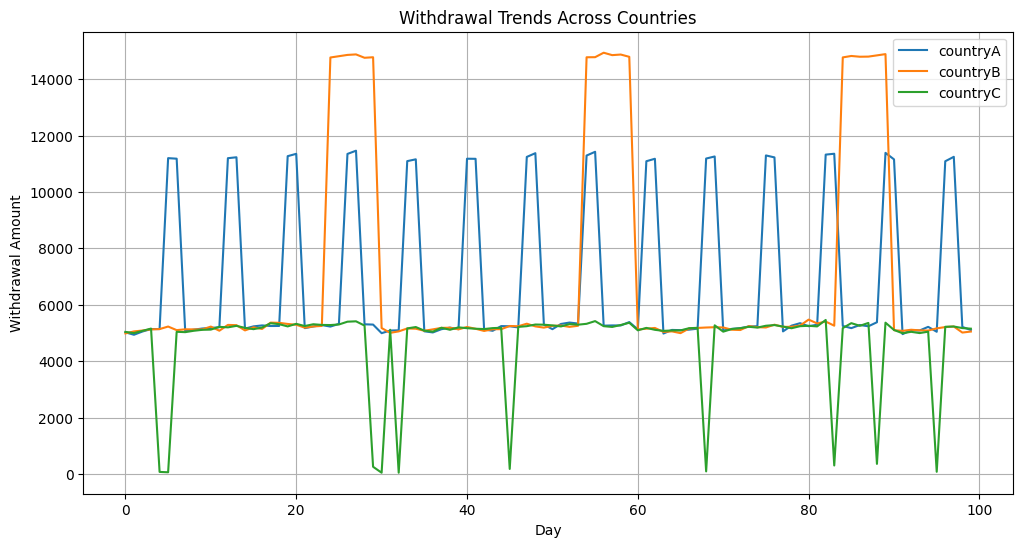

In [ ]:
import matplotlib.pyplot as plt

# List of filenames to plot
filenames = ['countryA.csv', 'countryB.csv', 'countryC.csv']

plt.figure(figsize=(12, 6)) # Adjust figure size as needed

for filename in filenames:
    df = pd.read_csv(filename)
    plt.plot(df.index, df['label'], label=f'{filename.split(".")[0]}')

plt.title('Withdrawal Trends Across Countries')
plt.xlabel('Day')
plt.ylabel('Withdrawal Amount')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

# Hyperparameters
learning_rate = 0.005
num_epochs = 5000
mse_threshold = 1e-4

# Define simple model (better than plain linear)
class ATMNet(nn.Module):
    def __init__(self, input_dim):
        super(ATMNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# Evaluation metrics
def compute_mape(y_true, y_pred):
    return (torch.abs((y_true - y_pred) / (y_true.abs() + 1e-6))).mean().item() * 100

# Load CSV, Normalize Inputs, Keep Labels as-is
def load_country_data(filepath):
    df = pd.read_csv(filepath)
    X = df[['day_of_week', 'day_of_month', 'is_holiday', 'country_id']].values.astype(np.float32)
    y = df['label'].values.astype(np.float32)

    # Normalize inputs
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-6
    X_norm = (X - X_mean) / X_std

    X_tensor = torch.tensor(X_norm, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    return X_tensor, y_tensor

# Main Training Loop per Country
def train_country(filepath, country_id):
    X, y = load_country_data(filepath)
    model = ATMNet(input_dim=X.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 or epoch == num_epochs - 1:
            mape = compute_mape(y, y_pred.detach())
            print(f"Country {country_id} Epoch {epoch} MSE: {loss.item():.2f} MAPE: {mape:.2f}%")

        if loss.item() < mse_threshold:
            print(f"Country {country_id} converged at epoch {epoch}")
            break

    return model

# Train Models Per Country
countries = ['countryA.csv', 'countryB.csv', 'countryC.csv']

for idx, file in enumerate(countries, start=1):
    print(f"\nTraining Model for Country {idx} ({file})")
    train_country(file, idx)



Training Model for Country 1 (countryA.csv)
Country 1 Epoch 0 MSE: 54763740.00 MAPE: 100.00%
Country 1 Epoch 500 MSE: 50333708.00 MAPE: 95.91%
Country 1 Epoch 1000 MSE: 38634672.00 MAPE: 84.34%
Country 1 Epoch 1500 MSE: 25236214.00 MAPE: 68.21%
Country 1 Epoch 2000 MSE: 14445229.00 MAPE: 50.42%
Country 1 Epoch 2500 MSE: 8030384.00 MAPE: 37.08%
Country 1 Epoch 3000 MSE: 5144791.00 MAPE: 31.35%
Country 1 Epoch 3500 MSE: 3882107.00 MAPE: 27.76%
Country 1 Epoch 4000 MSE: 3169119.00 MAPE: 25.42%
Country 1 Epoch 4500 MSE: 2733818.25 MAPE: 23.62%
Country 1 Epoch 4999 MSE: 2480271.25 MAPE: 22.25%

Training Model for Country 2 (countryB.csv)
Country 2 Epoch 0 MSE: 61525688.00 MAPE: 100.00%
Country 2 Epoch 500 MSE: 56929076.00 MAPE: 95.71%
Country 2 Epoch 1000 MSE: 44813884.00 MAPE: 83.89%
Country 2 Epoch 1500 MSE: 31022760.00 MAPE: 67.50%
Country 2 Epoch 2000 MSE: 19819690.00 MAPE: 51.73%
Country 2 Epoch 2500 MSE: 12841267.00 MAPE: 44.21%
Country 2 Epoch 3000 MSE: 9397124.00 MAPE: 40.56%
Count

In [ ]:
%%writefile admm.cu

#include <iostream>
#include <fstream>
#include <sstream>
#include <cmath>
#include <vector>
#include <string>
#include <algorithm>
#include <cuda_runtime.h>

const int n_countries = 3;
const int n_features = 4;
const int n_samples = 10;
const float lr = 0.01f;
const float rho = 1.0f;
const int local_gd_steps = 1000;
const int threads_per_block = 256;
const float mse_threshold = 1e-4f;
const int max_iters = 10000;
const int print_interval = 500;
const int stop_window = 20;
const float z_tol = 1e-10f;

float label_mean[n_countries];
float label_maxabs[n_countries];

void read_csv(const std::string& filename, float* X, float* y) {
    std::ifstream file(filename);
    std::string line;
    std::getline(file, line);
    int row = 0;
    while (std::getline(file, line) && row < n_samples) {
        std::stringstream ss(line);
        std::string value;
        for (int j = 0; j < n_features; j++) {
            std::getline(ss, value, ',');
            X[row * n_features + j] = std::stof(value);
        }
        std::getline(ss, value, ',');
        y[row] = std::stof(value);
        row++;
    }
}

void normalize_features(float* X, int num_rows, int num_features) {
    for (int j = 0; j < num_features; j++) {
        float mean = 0.0f;
        float max_abs = 0.0f;
        for (int i = 0; i < num_rows; i++) {
            float val = X[i * num_features + j];
            mean += val;
            max_abs = std::max(max_abs, std::abs(val));
        }
        mean /= num_rows;
        printf ("normalize_features Feature (%d), Mean = %.4f max_abs = %.4f \n", j, mean, max_abs);
        if (max_abs == 0.0f) max_abs = 1.0f;
        for (int i = 0; i < num_rows; i++) {
            X[i * num_features + j] = (X[i * num_features + j] - mean) / max_abs;
        }
    }
}

void normalize_labels(float* y, int num_rows, int country_idx) {
    float mean = 0.0f;
    float max_abs = 0.0f;
    for (int i = 0; i < num_rows; i++) {
        mean += y[i];
        max_abs = std::max(max_abs, std::abs(y[i]));
    }
    mean /= num_rows;
    if (max_abs == 0.0f) max_abs = 1.0f;
    for (int i = 0; i < num_rows; i++) {
        y[i] = (y[i] - mean) / max_abs;
    }
    label_mean[country_idx] = mean;
    label_maxabs[country_idx] = max_abs;
    printf("normalize_labels country_idx (%d), label_mean[%d] = %.4f label_maxabs[%d] = %.4f\n",
           country_idx, country_idx, label_mean[country_idx], country_idx, label_maxabs[country_idx]);
}


__global__ void admm_primal_update_kernel(
    float* X, float* y, float* w_local, const float* z, const float* lambda,
    float* mse_out, float* mape_out,
    int n_samples, int n_features, float rho, float label_mean, float label_maxabs
) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    extern __shared__ float grad[];

    for (int iter = 0; iter < local_gd_steps; iter++) {
        if (threadIdx.x < n_features)
            grad[threadIdx.x] = 0.0f;
        __syncthreads();

        for (int i = idx; i < n_samples; i += blockDim.x * gridDim.x) {
            float pred = 0.0f;
            for (int j = 0; j < n_features; j++)
                pred += X[i * n_features + j] * w_local[j];
            float err = pred - y[i];
            for (int j = 0; j < n_features; j++) {
                atomicAdd(&grad[j], err * X[i * n_features + j]);
            }
        }
        __syncthreads();

        if (threadIdx.x < n_features) {
            grad[threadIdx.x] = grad[threadIdx.x] / n_samples + rho * (w_local[threadIdx.x] - z[threadIdx.x] + lambda[threadIdx.x]);
            w_local[threadIdx.x] -= lr * grad[threadIdx.x];
        }
        __syncthreads();
    }

    if (threadIdx.x == 0) {
        float mse = 0.0f;
        for (int i = 0; i < n_samples; i++) {
            float pred = 0.0f;
            for (int j = 0; j < n_features; j++)
                pred += X[i * n_features + j] * w_local[j];
            float actual = y[i];
            float diff = pred - actual;
            mse += diff * diff;
        }
        mse_out[0] = mse / n_samples;
    }
}

void save_weights_to_csv(const char* filename, float* w_country[], int n_countries, int n_features) {
    std::ofstream file(filename);
    for (int c = 0; c < n_countries; c++) {
        for (int j = 0; j < n_features; j++) {
            file << w_country[c][j];
            if (j < n_features - 1)
                file << ",";
        }
        file << "\n";
    }
    file.close();
}

int main() {
    float* X_country[n_countries];
    float* y_country[n_countries];
    float* w_country[n_countries];
    float* lambda_country[n_countries];
    float z[n_features] = {0};
    float z_history[stop_window] = {0};
    int z_hist_idx = 0;

    std::string filenames[n_countries] = {"countryA.csv", "countryB.csv", "countryC.csv"};

    for (int c = 0; c < n_countries; c++) {
        X_country[c] = new float[n_samples * n_features];
        y_country[c] = new float[n_samples];
        w_country[c] = new float[n_features]{0};
        lambda_country[c] = new float[n_features]{0};

        read_csv(filenames[c], X_country[c], y_country[c]);
        normalize_features(X_country[c], n_samples, n_features);
        normalize_labels(y_country[c], n_samples, c);
    }

    std::ofstream log_file("training_log.csv");
    log_file << "Iteration";
    for (int c = 0; c < n_countries; c++)
        log_file << ",Country" << (c+1) << "_MSE";
    log_file << "\n";

    int iter = 0;
    bool converged = false;

    while (iter < max_iters && !converged) {
        iter++;

        float mse_vals[n_countries] = {0};

        for (int c = 0; c < n_countries; c++) {
            float *d_X, *d_y, *d_w, *d_z, *d_lambda, *d_mse;
            cudaMalloc(&d_X, n_samples * n_features * sizeof(float));
            cudaMalloc(&d_y, n_samples * sizeof(float));
            cudaMalloc(&d_w, n_features * sizeof(float));
            cudaMalloc(&d_z, n_features * sizeof(float));
            cudaMalloc(&d_lambda, n_features * sizeof(float));
            cudaMalloc(&d_mse, sizeof(float));

            cudaMemcpy(d_X, X_country[c], n_samples * n_features * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_y, y_country[c], n_samples * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_w, w_country[c], n_features * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_z, z, n_features * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_lambda, lambda_country[c], n_features * sizeof(float), cudaMemcpyHostToDevice);

            int num_blocks = (n_samples + threads_per_block - 1) / threads_per_block;
            size_t shared_mem_size = n_features * sizeof(float);
            admm_primal_update_kernel<<<num_blocks, threads_per_block, shared_mem_size>>>(d_X, d_y, d_w, d_z, d_lambda, d_mse, nullptr, n_samples, n_features, rho, label_mean[c], label_maxabs[c]);

            cudaMemcpy(w_country[c], d_w, n_features * sizeof(float), cudaMemcpyDeviceToHost);
            cudaMemcpy(&mse_vals[c], d_mse, sizeof(float), cudaMemcpyDeviceToHost);

            cudaFree(d_X);
            cudaFree(d_y);
            cudaFree(d_w);
            cudaFree(d_z);
            cudaFree(d_lambda);
            cudaFree(d_mse);
        }

        // Log MSE values to CSV
        log_file << iter;
        for (int c = 0; c < n_countries; c++) {
            log_file << "," << mse_vals[c];
        }
        log_file << "\n";

        float z_sum = 0.0f;
        for (int j = 0; j < n_features; j++) {
            float sum = 0.0f;
            for (int c = 0; c < n_countries; c++)
                sum += w_country[c][j] + lambda_country[c][j];
            z[j] = sum / n_countries;
            z_sum += fabs(z[j]);
        }

        z_history[z_hist_idx % stop_window] = z_sum;
        z_hist_idx++;

        if (iter >= stop_window) {
            float max_diff = 0.0f;
            for (int k = 1; k < stop_window; k++) {
                float diff = fabs(z_history[k] - z_history[k - 1]);
                if (diff > max_diff)
                    max_diff = diff;
            }
            if (max_diff < z_tol)
                converged = true;
        }

        if (iter % print_interval == 0 || converged) {
            printf("Iteration %d | MSEs: ", iter);
            for (int c = 0; c < n_countries; c++) {
                printf("Country %d MSE=%.6f ", c + 1, mse_vals[c]);
            }
            printf("| Global Z: ");
            for (int j = 0; j < n_features; j++)
                printf("%.4f ", z[j]);
            printf("\n");
        }

        for (int c = 0; c < n_countries; c++) {
            for (int j = 0; j < n_features; j++)
                lambda_country[c][j] += w_country[c][j] - z[j];
        }
    }

    log_file.close();

    printf("\n=== Final Validation on Training Data ===\n");
    for (int c = 0; c < n_countries; c++) {
        float mse = 0.0f;
        for (int i = 0; i < n_samples; i++) {
            float pred = 0.0f;
            for (int j = 0; j < n_features; j++)
                pred += X_country[c][i * n_features + j] * w_country[c][j];

            float diff = pred - y_country[c][i];
            mse += diff * diff;
        }
        mse /= n_samples;

        printf("Country %d Validation MSE=%.6f\n", c + 1, mse);
    }

    save_weights_to_csv("weights.csv", w_country, n_countries, n_features);
    printf("Saved weights to weights.csv\n");

    for (int c = 0; c < n_countries; c++) {
        delete[] X_country[c];
        delete[] y_country[c];
        delete[] w_country[c];
        delete[] lambda_country[c];
    }

    return 0;
}



Overwriting admm.cu


In [ ]:
!nvcc -gencode arch=compute_75,code=sm_75 admm.cu -o admm
!time ./admm

admm.cu(21): warning #177-D: variable "mse_threshold" was declared but never referenced
  const float mse_threshold = 1e-4f;
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

normalize_features Feature (0), Mean = 2.4000 max_abs = 6.0000 
normalize_features Feature (1), Mean = 5.5000 max_abs = 10.0000 
normalize_features Feature (2), Mean = 0.0000 max_abs = 0.0000 
normalize_features Feature (3), Mean = 1.0000 max_abs = 1.0000 
normalize_labels country_idx (0), label_mean[0] = 6302.9043 label_maxabs[0] = 11198.1006
normalize_features Feature (0), Mean = 2.4000 max_abs = 6.0000 
normalize_features Feature (1), Mean = 5.5000 max_abs = 10.0000 
normalize_features Feature (2), Mean = 0.0000 max_abs = 0.0000 
normalize_features Feature (3), Mean = 2.0000 max_abs = 2.0000 
normalize_labels country_idx (1), label_mean[1] = 5112.5708 label_maxabs[1] = 5230.3350
normalize_features Feature (0), Mean = 2.4000 max_abs = 6.0000 
normalize_features Featu

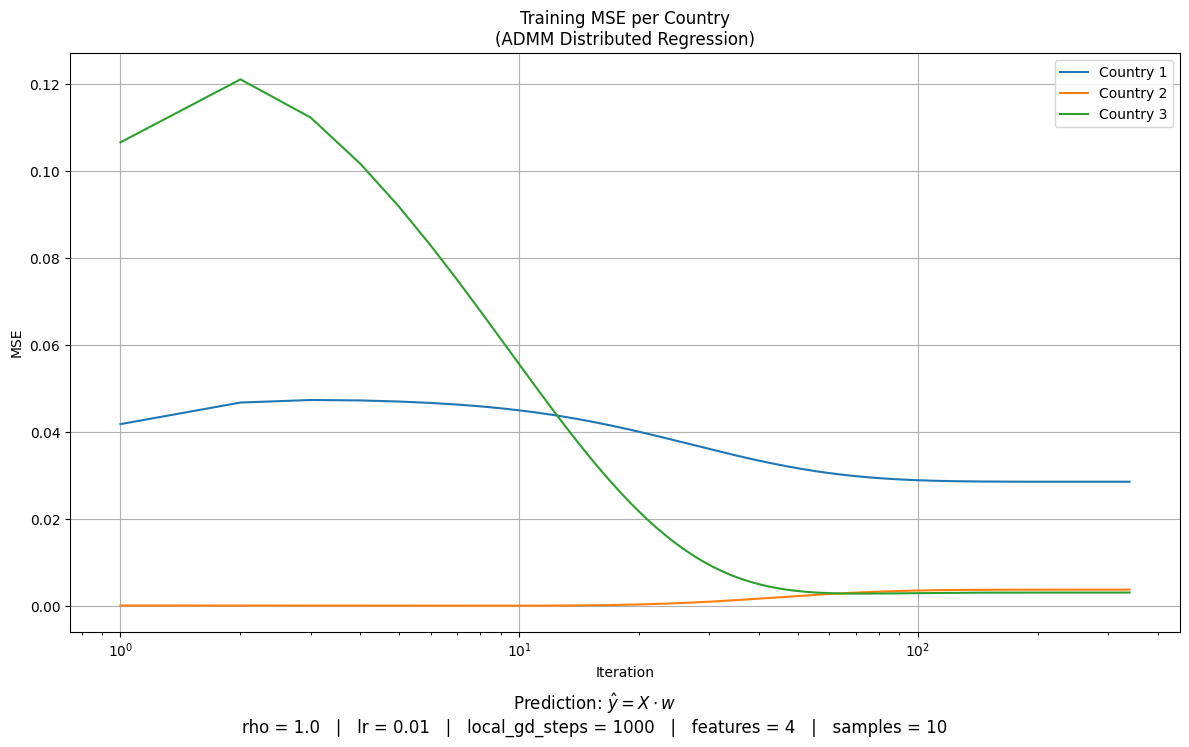

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load CSV
df = pd.read_csv('training_log.csv')

# Training Parameters (Set as per your experiment)
rho = 1.0
lr = 0.01
local_gd_steps = 1000
n_features = 4
n_samples = 10
max_iters = 10000

# Plot
plt.figure(figsize=(12, 7))

for c in range(1, 4):
    plt.plot(df['Iteration'], df[f'Country{c}_MSE'], label=f'Country {c}')

plt.xlabel('Iteration')
plt.ylabel('MSE')
# put x on log
plt.xscale('log')
plt.title('Training MSE per Country\n(ADMM Distributed Regression)')
plt.legend()
plt.grid(True)

# Add equation text below plot
equation_text = (
    r"Prediction: $\hat{y} = X \cdot w$" + "\n"
    f"rho = {rho}   |   lr = {lr}   |   local_gd_steps = {local_gd_steps}   |   features = {n_features}   |   samples = {n_samples}"
)
plt.figtext(0.5, -0.05, equation_text, wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()


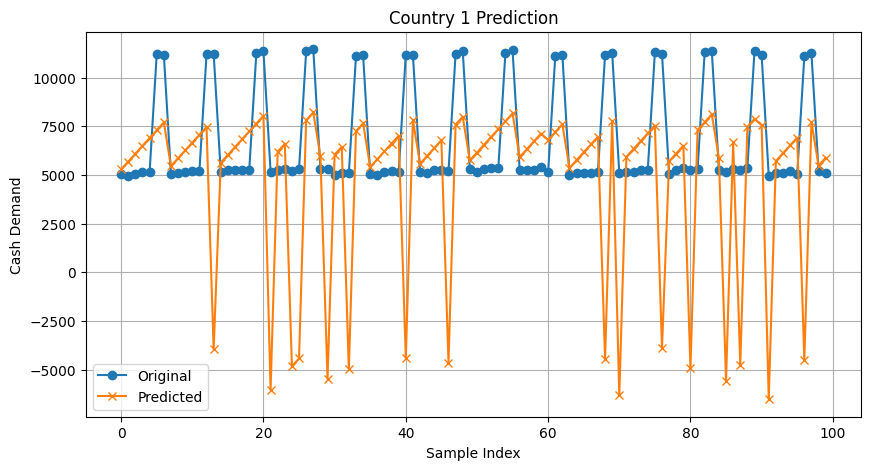

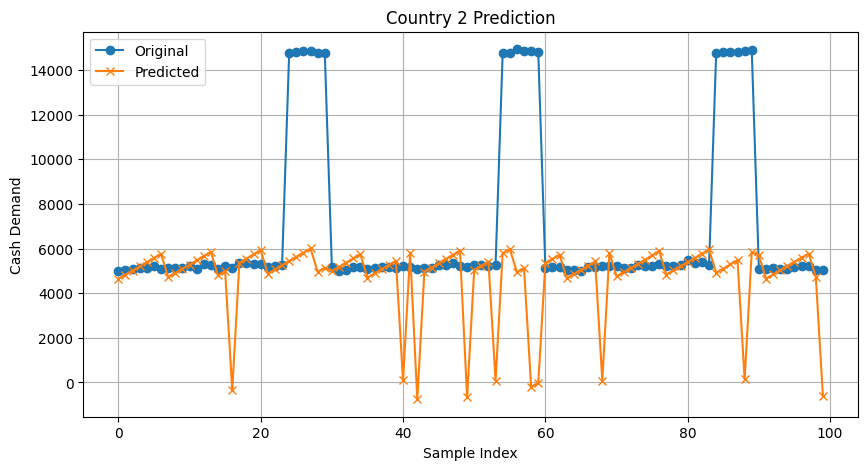

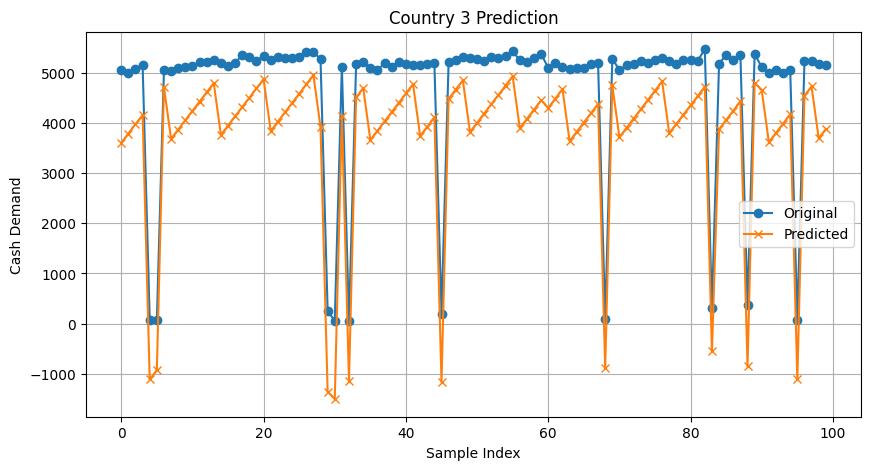

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load consensus weights (assuming 3 weights per row)
weights = np.loadtxt('weights.csv', delimiter=',')

# Load normalization stats
label_means = [6302.9043, 5112.5708, 4068.9062]
label_maxabs = [11198.1006, 5230.3350, 5158.3940]

# Load features and labels
X_list = []
y_list = []
for country in ['countryA', 'countryB', 'countryC']:
    data = np.loadtxt(f'{country}.csv', delimiter=',', skiprows=1)
    X_list.append(data[:, :-1])
    y_list.append(data[:, -1])

feature_means = [2.4, 5.5, 0.0, 1.0]
feature_maxabs_countryA = [6.0, 10.0, 1.0, 1.0]  # last used unless dead feature ignored

def normalize_features(X, means, maxabs_list):
    X_norm = []
    for j in range(X.shape[1]):
        if maxabs_list[j] == 0.0:
            continue  # skip dead features
        col = (X[:, j] - means[j]) / maxabs_list[j]
        X_norm.append(col)
    return np.column_stack(X_norm)

# Predict and plot
for i, (X, y_true) in enumerate(zip(X_list, y_list)):
    maxabs_features = feature_maxabs_countryA.copy()
    if i == 1:
        maxabs_features[3] = 2.0
    elif i == 2:
        maxabs_features[2] = 1.0
        maxabs_features[3] = 3.0

    X_use = normalize_features(X, feature_means, maxabs_features)

    y_pred_norm = X_use @ weights[i]  # Each weights[i] is now matching reduced features

    y_pred = y_pred_norm * label_maxabs[i] + label_means[i]

    plt.figure(figsize=(10, 5))
    plt.plot(y_true, 'o-', label='Original')
    plt.plot(y_pred, 'x-', label='Predicted')
    plt.title(f'Country {i+1} Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Cash Demand')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
!cat weights.csv

0.202398,0.0217265,-1.05694,0
0.202398,0.0217265,-1.05694,0
0.202398,0.0217265,-1.05694,0
